In [11]:
%matplotlib widget
import numpy as np
import cuml
from cuml import KMeans
from cuml.cluster import KMeans
import cudf
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
timeZone = pytz.timezone('America/Los_Angeles')

import torch

import myUtils
import torchModels

In [2]:
def reconstruct(toPredict, predictorModel, kmeansModel, nStack):
    predicted = np.zeros_like(toPredict)
    predicted[:,1] = toPredict[:,1]

    #stackedSamples, _ = residualStack.shape
    _, nSamples = toPredict.shape
    counter = 1

    while counter + nStack <= nSamples:
        if counter % 100000 == 0:
            myPrint("predicting sample: " + str(counter))

        thisToPredict = toPredict[:, counter:counter + nStack].flatten(order='F')
        thisPredictor = np.repeat(predicted[:, counter - 1], nStack)
        thisResidual = thisToPredict - thisPredictor
        
        #kmeansModel.fit(np.expand_dims(thisResidual,0))
        
        index = int(kmeans.predict(np.expand_dims(thisResidual, 0))[0])
        thisCentroid = centroids[index,:]
        for j in range(nStack):
            predicted[:, counter] = data[:, counter - 1 - j] + thisCentroid[j * nChannel: (j+1) * nChannel].transpose()
            counter += 1
            
    return predicted, kmeansModel

# Load data

In [9]:
dataMultiply = 10**5
sFreq = 256
arrayInCompressedFile = 'arr_7'

data = np.load('/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/elimPeaksSVD001.npz')[arrayInCompressedFile]
nChannel, nSample = data.shape
data = (data * dataMultiply).astype('float32')
dataTensor = torch.tensor(data)
if torch.cuda.is_available():
    dataTensor = dataTensor.to('cuda')
    print("Data has been moved to GPU")
else:
    print("Data is on CPU")
print(data.shape)

Data has been moved to GPU
(19, 1100367)


In [41]:
# Set parameters
modelType = 'kmeans'
loadBool = 1
modelPath = '/blue/gkalamangalam/jmark.ettinger/eegCompress/models/savedModel_04-16 00:52_-0.023.pt'
numSampleInput = 20
numSampleOutput = 1

path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/kmeansModels/kmeansModel_001_block7_1stack.npz'
npzfile = np.load(path)
centroids = npzfile['arr_0']
initDict = {'kmeansInit': centroids, 'dataTensor': dataTensor, 'numSampleInput':numSampleInput}

model, dataset, loss_function = torchModels.makeModel(modelType, initDict)
model = model.to('cuda')
numSampleInput = model.numSampleInput

In [50]:
batchSize = 1

centroids = model.kmeans.float().detach().cpu().numpy()
nCentroids,_ = centroids.shape
kmeans = KMeans(n_clusters=nCentroids, init=centroids, n_init=1)

loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False, sampler=None)

# Reconstruct the data from predictions and centroids

In [56]:
%%time
#def reconstruct(toPredict, predictorModel, kmeansModel, nStack):

nStack = 1
toPredict = dataTensor
predictionModel = model
kmeansModel = kmeans

model.eval()
predicted = np.zeros_like(toPredict.detach().cpu().numpy())
predicted[:,0:numSampleInput] = toPredict[:,0:numSampleInput].detach().cpu().numpy()

counter = numSampleInput
for (thisBlock, label) in loader:
    if counter % 100000 == 0:
        print(counter)
    thisPrediction = predictionModel(thisBlock)
    thisResidual = (label - thisPrediction).detach().cpu().numpy().transpose()
    
    index = int(kmeans.predict(np.expand_dims(thisResidual, 0))[0])
    thisCentroid = centroids[index,:]
    predicted[:,counter] = thisCentroid
    
    for j in range(nStack):
        predicted[:, counter] = data[:, counter - 1 - j] + thisCentroid[j * nChannel: (j+1) * nChannel].transpose()
        counter += 1
        
    counter += 1

model.train()


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


IndexError: index 1100367 is out of bounds for axis 1 with size 1100367

In [58]:
counter

1100367

In [59]:
np.mean(np.abs(data - predicted)), np.max(np.abs(data - predicted))

(np.float32(0.67887247), np.float32(132.24344))

 current best: (0.044626124, 0.6939485)

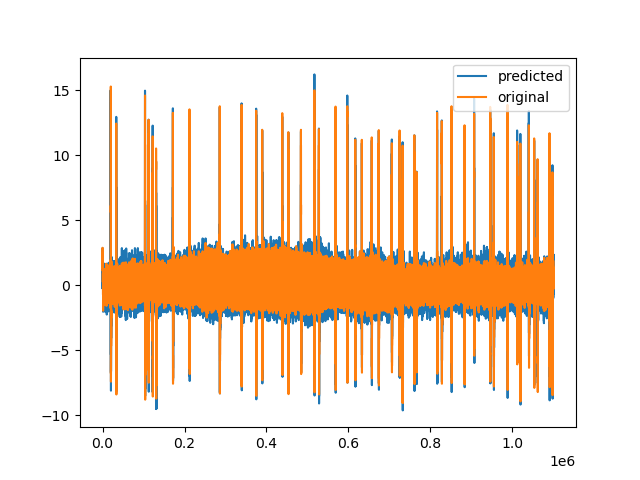

In [60]:
channel = 0

plt.figure()
plt.plot(predicted[channel,:], label='predicted')
plt.plot(data[channel,:], label='original')
residual = data - predicted
#plt.plot(residual[channel,:])
plt.legend()
plt.show()

# Save original and predicted

In [ ]:
path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/origAndPredictedLossy.npz'
dataToSaveList = [data[:,0:failureIndex], predicted[:, 0:failureIndex]]
np.savez_compressed(path, *dataToSaveList)

# Scratch